# Random Forest Regression for Soil Moisture Prediction in Apayao

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Test RMSE: 41.951
Test MAE: 33.118
AIC: 986.963
BIC: 998.464

Unseen RMSE: 65.732
Unseen MAE: 52.223
Unseen AIC: 619.095
Unseen BIC: 628.257


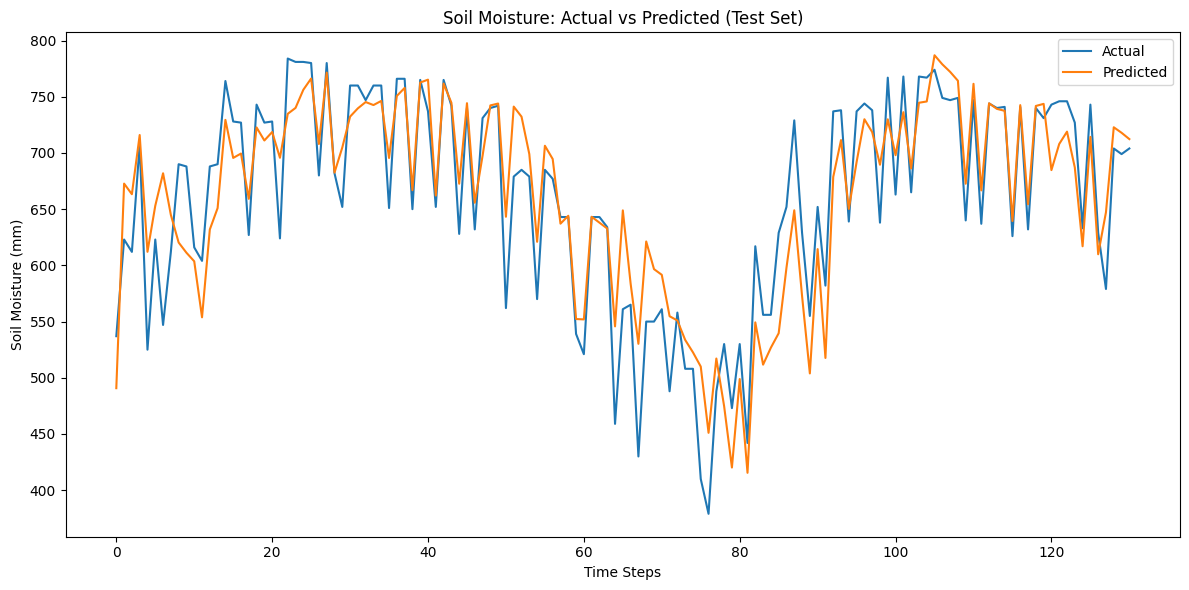

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from math import log, sqrt
import matplotlib.pyplot as plt
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('Apayao.csv')

# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y')

# Sort by time
df = df.sort_values('Time')

# Create lag features (t-1, t-2, t-3) for soil moisture
df['Soil_Moisture_Lag1'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(1)
df['Soil_Moisture_Lag2'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(2)
df['Soil_Moisture_Lag3'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(3)

# Drop rows with NaN values (first 3 rows for each municipality)
df = df.dropna()

# Define features and target
# As per requirements, we'll only use soil moisture as a feature
X = df[['Soil_Moisture_Lag1', 'Soil_Moisture_Lag2', 'Soil_Moisture_Lag3']]
y = df['Soil Moisture (mm)']

# Split into seen (90%) and unseen (10%) sets
seen_size = int(len(df) * 0.9)
X_seen = X[:seen_size]
y_seen = y[:seen_size]
X_unseen = X[seen_size:]
y_unseen = y[seen_size:]

# Split seen data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_seen, y_seen, test_size=0.2, random_state=42, shuffle=False
)

# Define parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Initialize model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)

# Implement Rolling Forecast Origin Method
# We'll use the training data and incrementally add test data points
train_size = len(X_train)
test_size = len(X_test)
predictions = []
actuals = []

for i in range(test_size):
    # Train on all available training data
    X_train_rolling = X_seen[:train_size + i]
    y_train_rolling = y_seen[:train_size + i]

    # Fit the model
    best_rf.fit(X_train_rolling, y_train_rolling)

    # Predict the next point
    next_pred = best_rf.predict([X_seen.iloc[train_size + i]])
    predictions.append(next_pred[0])
    actuals.append(y_seen.iloc[train_size + i])

# Calculate metrics for the test set
rmse_test = sqrt(mean_squared_error(actuals, predictions))
mae_test = mean_absolute_error(actuals, predictions)

# Calculate AIC and BIC
n = len(actuals)
k = X.shape[1] + 1  # number of parameters (+1 for intercept)
rss = sum((np.array(actuals) - np.array(predictions))**2)
mse = rss / n
aic = n * log(mse) + 2 * k
bic = n * log(mse) + k * log(n)

print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test MAE: {mae_test:.3f}")
print(f"AIC: {aic:.3f}")
print(f"BIC: {bic:.3f}")

# Now predict on the unseen set
best_rf.fit(X_seen, y_seen)  # Train on all seen data
unseen_predictions = best_rf.predict(X_unseen)

# Calculate metrics for the unseen set
rmse_unseen = sqrt(mean_squared_error(y_unseen, unseen_predictions))
mae_unseen = mean_absolute_error(y_unseen, unseen_predictions)

# Calculate AIC and BIC for unseen data
n_unseen = len(y_unseen)
rss_unseen = sum((np.array(y_unseen) - np.array(unseen_predictions))**2)
mse_unseen = rss_unseen / n_unseen
aic_unseen = n_unseen * log(mse_unseen) + 2 * k
bic_unseen = n_unseen * log(mse_unseen) + k * log(n_unseen)

print(f"\nUnseen RMSE: {rmse_unseen:.3f}")
print(f"Unseen MAE: {mae_unseen:.3f}")
print(f"Unseen AIC: {aic_unseen:.3f}")
print(f"Unseen BIC: {bic_unseen:.3f}")

# # Predict next month's soil moisture for each municipality
# last_data = df.groupby('Municipal').last()
# next_month_predictions = {}
#
# for municipality in df['Municipal'].unique():
#     # Get the last 3 soil moisture values for this municipality
#     last_values = df[df['Municipal'] == municipality].tail(3)['Soil Moisture (mm)'].values
#
#     # Create feature vector for prediction
#     if len(last_values) >= 3:
#         features = [[last_values[2], last_values[1], last_values[0]]]
#         prediction = best_rf.predict(features)[0]
#         next_month_predictions[municipality] = prediction
#
# print("\nPredicted soil moisture for next month:")
# for municipality, prediction in next_month_predictions.items():
#     print(f"{municipality}: {prediction:.2f} mm")

# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Soil Moisture: Actual vs Predicted (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Soil Moisture (mm)')
plt.legend()
plt.tight_layout()
# plt.savefig('soil_moisture_prediction.png')
plt.show()
plt.close()

# # Feature importance
# feature_importance = pd.DataFrame(
#     {'Feature': X.columns, 'Importance': best_rf.feature_importances_}
# ).sort_values('Importance', ascending=False)
#
# print("\nFeature Importance:")
# print(feature_importance)
